In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (12, 8)

# Load the data matrix

We load 20 natural images from the Kyoto dataset and rescale the images to size (250, 320). 

In [4]:
from scipy.io import loadmat

def load_matrix(path):
    """
    Load the dataset each matrix at a time and
    combine the color changes such that (L, M, S) <-> (R, G, B)
    and all images have dimensions (250, 320).
    """
    channels = ("OL", "OM", "OS")
    image = np.dstack([loadmat(path)[c] for c in channels])
    if image.shape != (500, 640, 3):
        image = image.transpose(1, 0, 2)
    image = Image.fromarray((image*255).astype(np.uint8))
    image.thumbnail((320, 320))
    image = np.array(image)/255
    return image

base_path = "/Users/jesperwohlerthansen/Downloads/eizaburo-doi-kyoto_natim-c2015ff/osLMS0103-{}.mat"
images = np.array([load_matrix(base_path.format(i)) for i in range(1, 35)])

Extracting images patches of size (11, 11, 3), we display them.

In [5]:
from sklearn.feature_extraction.image import extract_patches_2d

size, channels = 11, 3

# Create 50000 (11, 11, 3) image patches from the first 20 images
patches = extract_patches_2d(np.vstack(images[:20]), (size, size), max_patches=50000)

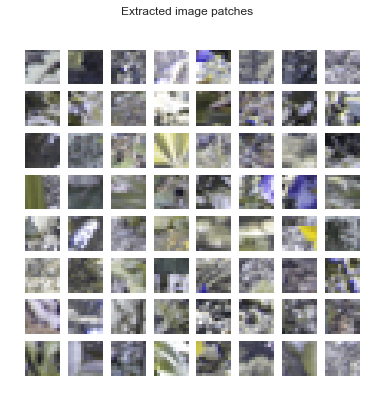

In [6]:
n = 8

image_patches = patches#(patches + mean).reshape(-1, size, size, channels)

f, axarr = plt.subplots(n, n, figsize=(6, 6))

for i in range(n**2):
    axarr[i//n, i%n].imshow(image_patches[i])
    axarr[i//n, i%n].axis("off")
    
f.suptitle("Extracted image patches")
plt.show()

## Principal Component Analysis

First we perform PCA on the image patches in order to see the learned components. These components will make up a Fourier basis of the images, where the eigenvalues represent the approximate frequency. As such they are ordered from low frequency (single color) to high frequency (grids of opposing colors).

In [7]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(patches.reshape(-1, size*size*channels))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

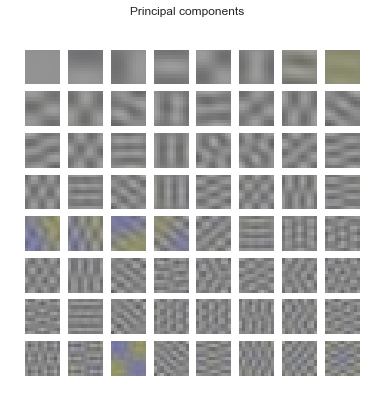

In [25]:
f, axarr = plt.subplots(n, n, figsize=(6, 6))

pca_components = (pca.components_ + pca.mean_).reshape(-1, size, size, channels)
#pca_components = np.random.permutation(pca_components)

for i in range(n**2):
    axarr[i//n, i%n].imshow(pca_components[i])
    axarr[i//n, i%n].axis("off")
    
f.suptitle("Principal components")
plt.show()

## Independent Component Analysis

We perform the same thing to find the independent components. These components maximise the kurtosis and independence in order to make plausible components similar to those in **V1**.

In [15]:
from sklearn.decomposition import FastICA

ica = FastICA()
ica.fit(patches.reshape(-1, size*size*channels)[:1000])

/Users/jesperwohlerthansen/miniconda3/envs/base/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=None, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

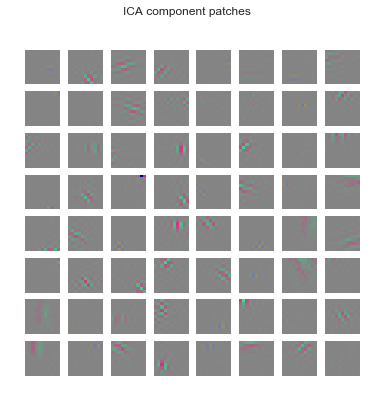

In [27]:
f, axarr = plt.subplots(n, n, figsize=(6, 6))

ica_components = np.load("ica.npz.npy")#(ica.components_ + ica.mean_).reshape(-1, size, size, channels)
ica_components = np.random.permutation(ica_components)

for i in range(n**2):
    axarr[i//n, i%n].imshow(ica_components[i])
    axarr[i//n, i%n].axis("off")
    
f.suptitle("ICA component patches")
plt.show()